# **Model**

In [3]:
import torch
!pip install einops
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from einops import rearrange
import matplotlib.pyplot as plt

class VAEModel(nn.Module):
    def __init__(self):
        super(VAEModel, self).__init__()

        self.common_fc = nn.Sequential(
            nn.Linear(784, 196),
            nn.Tanh(),
            nn.Linear(196, 48),
            nn.Tanh(),
        )

        self.mean_fc = nn.Sequential(
            nn.Linear(48, 16),
            nn.Tanh(),
            nn.Linear(16, 2),
        )

        self.log_var_fc = nn.Sequential(
            nn.Linear(48, 16),
            nn.Tanh(),
            nn.Linear(16, 2),
        )

        self.decoder_fcs = nn.Sequential(
            nn.Linear(2,16),
            nn.Tanh(),
            nn.Linear(16,48),
            nn.Tanh(),
            nn.Linear(48,196),
            nn.Tanh(),
            nn.Linear(196,784),
        )

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.sample(mean, log_var)
        out = self.decode(z)
        return mean, log_var, out

    def encode(self, x):
        out = self.common_fc(torch.flatten(x, start_dim=1))
        mean = self.mean_fc(out)
        log_var = self.log_var_fc(out)
        return mean, log_var

    def sample(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std)
        z = z * std + mean
        return z

    def decode(self, z):
        out = self.decoder_fcs(z)
        out = out.reshape((z.size(0),1,28,28))
        return out



# **Traning**

In [7]:
def train_vae():
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
    mnist_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

    model = VAEModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    recon_losses = []
    kl_losses = []
    losses = []
    for epoch in range(10):
        for im, label in tqdm(mnist_loader):
            im = im.float()
            optimizer.zero_grad()
            mean, log_var, out = model(im)

            recon_loss = criterion(out, im)
            kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()))
            loss = recon_loss + 1e-5 * kl_loss
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{10}, Recon Loss: {np.mean(recon_losses):.4f}, KL Loss: {np.mean(kl_losses):.4f}, Loss: {np.mean(losses):.4f}')

    print('Done Traning...')

    idxs = torch.randint(0, len(test_dataset) -1, (100,))
    ims = torch.cat([test_dataset[idx][0][None, :] for idx in idxs]).float()
    _, _, gen_img = model(ims)
    ims = (ims + 1) / 2
    gen_img = 1 - (gen_img + 1) / 2
    out = torch.hstack([ims,gen_img])
    output = rearrange(out, 'b c h w -> b () h (c w)')
    grid = torchvision.utils.make_grid(output, nrow=10)
    img = torchvision.transforms.ToPILImage()(grid)
    img.save('reconstruction.png')

    print('Done Reconstruction...')

    # Displaying the image


train_vae()


100%|██████████| 938/938 [00:15<00:00, 59.21it/s]


Epoch 1/10, Recon Loss: 0.0534, KL Loss: 219.2502, Loss: 0.0556


100%|██████████| 938/938 [00:15<00:00, 58.83it/s]


Epoch 2/10, Recon Loss: 0.0504, KL Loss: 253.0887, Loss: 0.0530


100%|██████████| 938/938 [00:16<00:00, 55.82it/s]


Epoch 3/10, Recon Loss: 0.0489, KL Loss: 270.5887, Loss: 0.0516


100%|██████████| 938/938 [00:15<00:00, 59.55it/s]


Epoch 4/10, Recon Loss: 0.0478, KL Loss: 281.6446, Loss: 0.0506


100%|██████████| 938/938 [00:15<00:00, 59.26it/s]


Epoch 5/10, Recon Loss: 0.0471, KL Loss: 289.5008, Loss: 0.0500


100%|██████████| 938/938 [00:15<00:00, 59.39it/s]


Epoch 6/10, Recon Loss: 0.0465, KL Loss: 295.4578, Loss: 0.0494


100%|██████████| 938/938 [00:16<00:00, 56.81it/s]


Epoch 7/10, Recon Loss: 0.0460, KL Loss: 300.4104, Loss: 0.0490


100%|██████████| 938/938 [00:15<00:00, 58.90it/s]


Epoch 8/10, Recon Loss: 0.0456, KL Loss: 304.5605, Loss: 0.0486


100%|██████████| 938/938 [00:15<00:00, 58.69it/s]


Epoch 9/10, Recon Loss: 0.0452, KL Loss: 308.1185, Loss: 0.0483


100%|██████████| 938/938 [00:16<00:00, 55.46it/s]

Epoch 10/10, Recon Loss: 0.0449, KL Loss: 311.2614, Loss: 0.0480
Done Traning...
Done Reconstruction...


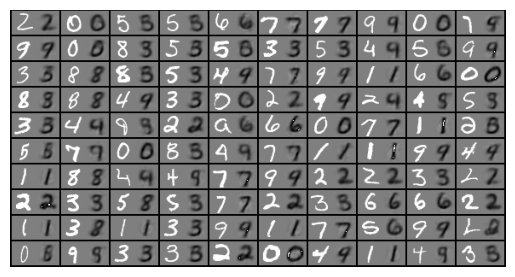

In [5]:
from PIL import Image
img = Image.open('reconstruction.png')
plt.imshow(img)
plt.axis('off')
plt.show()